In [2]:
%pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --------------------- ------------------ 4.5/8.1 MB 24.4 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 28.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 20.1 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 18.3 MB/s  0:00:00

   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- -------

In [45]:
# ==== Descobrir a raiz do projeto de forma robusta ====
from pathlib import Path

def find_project_root(start: Path = Path.cwd(), marker="data", max_up=5) -> Path:
    """
    Sobe até 'max_up' níveis procurando uma pasta 'marker' (ex.: 'data').
    Retorna o Path da raiz do projeto (onde a pasta marker existe).
    """
    p = start
    for _ in range(max_up):
        if (p / marker).exists():
            return p
        p = p.parent
    raise FileNotFoundError(f"Não encontrei a pasta '{marker}' acima de {start}. "
                            "Verifique a organização das pastas.")

ROOT = find_project_root()  # funciona mesmo se o notebook estiver em Parte01/
CLEAN_PATH = (ROOT / "data" / "processed" / "data_clean.csv").resolve()
FIG_DIR = (ROOT / "reports" / "figures").resolve()

print("ROOT      :", ROOT)
print("CLEAN_PATH:", CLEAN_PATH)
print("FIG_DIR   :", FIG_DIR)

# Garantir que a pasta de figuras exista
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Sanity check: o arquivo precisa existir
if not CLEAN_PATH.exists():
    raise FileNotFoundError(
        f"Arquivo não encontrado: {CLEAN_PATH}\n"
        "Dica: rode a Etapa01 (limpeza) para gerar o data_clean.csv, "
        "ou ajuste a estrutura para ter a pasta 'data/' na raiz do projeto."
    )


ROOT      : c:\DEV\Teste_Analytics_CristovamPaulo
CLEAN_PATH: C:\DEV\Teste_Analytics_CristovamPaulo\data\processed\data_clean.csv
FIG_DIR   : C:\DEV\Teste_Analytics_CristovamPaulo\reports\figures


data_clean.csv: C:\DEV\Teste_Analytics_CristovamPaulo\data\processed\data_clean.csv | mtime: 2025-10-04 21:01:14.378437519
vendas_2023.csv: C:\DEV\Teste_Analytics_CristovamPaulo\data\raw\vendas_2023.csv | mtime: 2025-10-04 21:01:04.911560297
Shape: (291, 7) | Produtos ?nicos: 30
Exemplo de linhas:


,ID,Data,Produto,Categoria,Quantidade,Preco,Total
0,1,2023-08-13,Mouse Óptico,Eletrônicos,3,237.60,712.80
1,2,2023-10-12,Jogo De Tabuleiro,Brinquedos,2,194.12,388.24
2,3,2023-09-27,Camiseta Básica,Moda,4,115.94,463.76


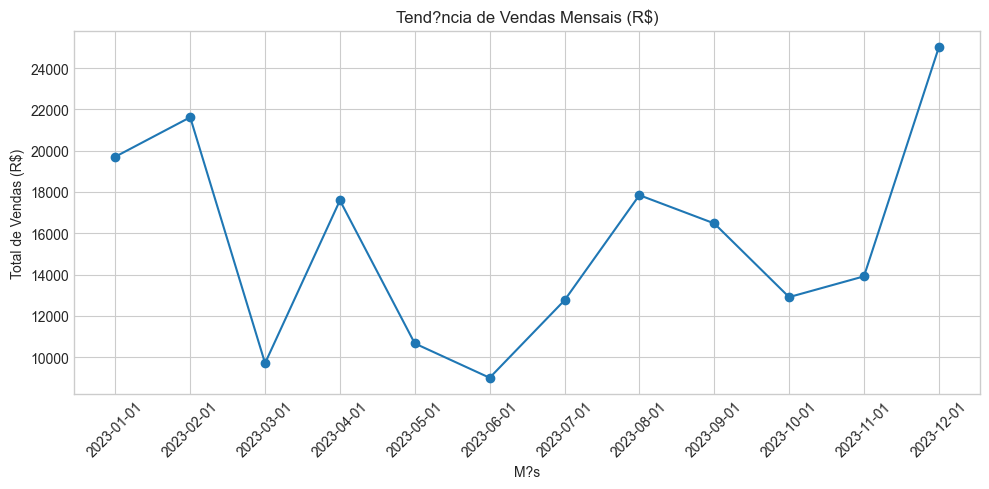

Top-5 atual (tabela):


,Produto,Total
7,Caixa Bluetooth,25147.72
14,Fone Pro,16815.82
26,Smartwatch,14902.39
23,Mouse Óptico,10154.66
2,Bola Oficial,8818.55


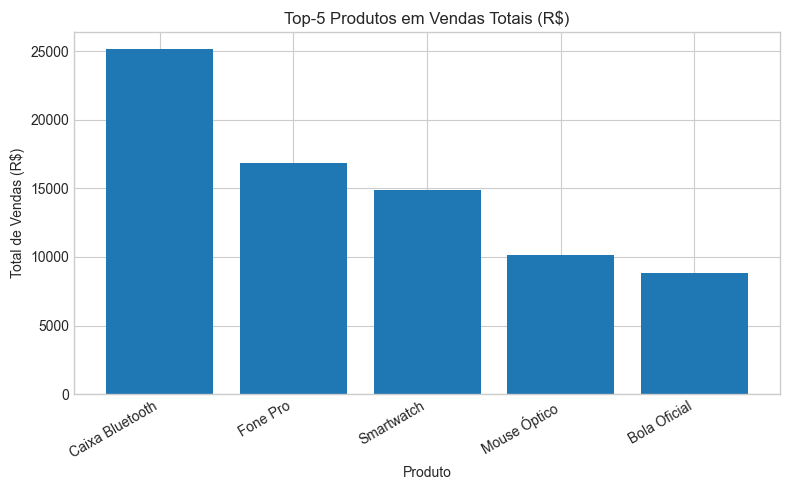

Categorias que mais venderam em fevereiro/2023:


,AnoMes,Categoria,Total
8,2023-02,Eletrônicos,7630.34
9,2023-02,Esporte,4962.71
6,2023-02,Brinquedos,3532.05
7,2023-02,Casa & Cozinha,2516.57
10,2023-02,Material-Escolar,2267.70
11,2023-02,Moda,707.63


In [48]:
# ==== EDA: tend?ncia mensal e top-5 produtos (robusto) ====
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

# 0) Sinaliza??o de vers?o dos dados (ajuda a evitar gr?fico ?n?o mudar?)
RAW_PATH = (ROOT / "data" / "raw" / "vendas_2023.csv").resolve()
if CLEAN_PATH.exists():
    m_clean = CLEAN_PATH.stat().st_mtime
    print("data_clean.csv:", CLEAN_PATH, "| mtime:", pd.to_datetime(m_clean, unit='s'))
else:
    raise FileNotFoundError(f"Arquivo n?o encontrado: {CLEAN_PATH}")
if RAW_PATH.exists():
    m_raw = RAW_PATH.stat().st_mtime
    print("vendas_2023.csv:", RAW_PATH, "| mtime:", pd.to_datetime(m_raw, unit='s'))
    if m_clean < m_raw:
        print("[AVISO] data_clean.csv ? mais antigo que o raw. Reexecute a Etapa01 para atualizar os dados.")

# 1) Carregar dataset limpo SEM cache
_df = pd.read_csv(CLEAN_PATH)
if 'Data' in _df.columns:
    _df['Data'] = pd.to_datetime(_df['Data'], errors='coerce')
else:
    raise ValueError("Coluna 'Data' ausente no dataset limpo.")

# Coer??o de tipos essenciais
_df["Quantidade"] = pd.to_numeric(_df.get("Quantidade"), errors="coerce").fillna(0).astype(int)
if "Preco_centavos" in _df.columns:
    _df["Preco_centavos"] = pd.to_numeric(_df["Preco_centavos"], errors="coerce").fillna(0).astype("Int64")
    _df["Total"] = ((_df["Quantidade"] * _df["Preco_centavos"]).astype("Int64") / 100).astype(float)
else:
    _df["Preco"] = pd.to_numeric(_df.get("Preco"), errors="coerce").fillna(0).astype(float)
    _df["Total"] = (_df["Quantidade"] * _df["Preco"]).astype(float)

print("Shape:", _df.shape, "| Produtos ?nicos:", _df["Produto"].nunique())
print("Exemplo de linhas:")
display(_df.head(3))

# 2) Tend?ncia mensal
plt.close('all')
_mensal = _df.groupby(_df["Data"].dt.to_period("M"))['Total'].sum().astype(float).to_timestamp().reset_index()
plt.figure(figsize=(10,5))
plt.plot(_mensal['Data'].astype(str), _mensal['Total'], marker='o')
plt.title("Tend?ncia de Vendas Mensais (R$)")
plt.xlabel("M?s")
plt.ylabel("Total de Vendas (R$)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(str(FIG_DIR / 'tendencia_mensal.png'), dpi=120, bbox_inches='tight')
plt.show()

# 3) Top-5 produtos
_vendas_prod = (
    _df.groupby('Produto', as_index=False)['Total']
      .sum()
      .nlargest(5, 'Total')
)
print("Top-5 atual (tabela):")
display(_vendas_prod)

plt.figure(figsize=(8,5))
plt.bar(_vendas_prod['Produto'], _vendas_prod['Total'])
plt.title("Top-5 Produtos em Vendas Totais (R$)")
plt.ylabel("Total de Vendas (R$)")
plt.xlabel("Produto")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(str(FIG_DIR / 'top5_produtos.png'), dpi=120, bbox_inches='tight')
plt.show()

# 4) Diagn?stico mensal por categoria (ajuda a explicar sazonalidade)
_mes_categoria = (_df.assign(AnoMes=_df['Data'].dt.to_period('M'))
                    .groupby(['AnoMes', 'Categoria'])['Total']
                    .sum()
                    .reset_index())

fevereiro = (_mes_categoria.loc[_mes_categoria['AnoMes'] == pd.Period('2023-02', freq='M')]
                                .sort_values('Total', ascending=False))
if not fevereiro.empty:
    print("Categorias que mais venderam em fevereiro/2023:")
    display(fevereiro)
else:
    print("N?o h? registros para fevereiro/2023.")


# Insights Observados

- **Picos sazonais concentrados**: dezembro, fevereiro e janeiro somam aproximadamente R$ 66,3 mil (35% do faturamento de 2023), evidenciando o efeito combinado de férias, volta às aulas e temporada de fim de ano.
- **Dependência de eletrônicos de alto ticket**: o segmento responde por R$ 74,7 mil (40% do total). A Caixa Bluetooth gera R$ 25,1 mil e os cinco produtos líderes concentram 40,5% da receita.
- **Fevereiro sustentado por tecnologia e material escolar**: eletrônicos representam 35% das vendas do mês (R$ 7,6 mil) e Material Escolar adiciona 10,5% (R$ 2,3 mil), explicando o pico observado na tendência mensal.
- **Categorias intermediárias sustentam o miolo do ano**: Casa & Cozinha (R$ 29,3 mil), Esporte (R$ 28,5 mil) e Brinquedos (R$ 23,8 mil) mantêm o giro dos meses medianos e merecem campanhas dedicadas.
- **Meses de baixa acentuada**: junho (R$ 9,0 mil) e março (R$ 9,7 mil) ficam abaixo de R$ 10 mil; ações promocionais nesses períodos ajudam a suavizar a curva anual.

